In [1]:
import pandas as pd

# Set display options to show all columns
pd.set_option('display.max_columns', None)

listings = pd.read_csv('final_listings.csv')

listings.head()

/Users/krys/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,host_verification_email,host_verification_phone,host_verification_work_email,wifi,heating,essentials,kitchen,smoke_alarm,air_conditioning,hangers,coffee_maker,dedicated_workspace,hot_water_kettle,hair_dryer,iron,tv,hot_water,washer,dryer,first_aid_kit,fire_extinguisher,refrigerator,pool,Gym,pets_allowed,free_parking_on_premises,paid_parking_on_premises,self_check-in,sentiment,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,neighbourhood_group_cleansed_Eixample,neighbourhood_group_cleansed_Gràcia,neighbourhood_group_cleansed_Horta-Guinardó,neighbourhood_group_cleansed_Les Corts,neighbourhood_group_cleansed_Nou Barris,neighbourhood_group_cleansed_Sant Andreu,neighbourhood_group_cleansed_Sant Martí,neighbourhood_group_cleansed_Sants-Montjuïc,neighbourhood_group_cleansed_Sarrià-Sant Gervasi,property_type_Boat,property_type_Camper/RV,property_type_Casa particular,property_type_Earthen home,property_type_Entire cabin,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in boat,property_type_Private room in casa particular,property_type_Private room in chalet,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in dome,property_type_Private room in floor,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in rental unit,property_type_Private room in serviced apartment,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hostel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room in bed and breakfast,property_type_Shared room in boutique hotel,property_type_Shared room in condo,property_type_Shared room in floor,property_type_Shared room in guest suite,property_type_Shared room in guesthouse,property_type_Shared room in home,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in serviced apartment,property_type_Shared room in villa,property_type_Tiny home,property_type_Yurt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.799129,1.000000,0.086502,0.002848,1.0,1.0,0.476053,0.636848,0.066667,0.020000,0.02,0.011923,0.135514,0.005343,0.253084,0.042433,0.014155,0.009804,0.9350,0.965124,0.886812,0.905000,0.958,0.947361,0.891019,1.0,0.128569,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666727,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro

# Separate features and target
X = listings.drop(columns=["price"])
y = listings["price"]


# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)


def perform_cross_validation(X, y, model, kf):
    mse_scores = []
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    residuals = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate residuals
        residuals.extend(y_test - y_pred)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    return np.mean(mse_scores), np.mean(mae_scores), np.mean(rmse_scores), np.mean(r2_scores), residuals


def plot_residuals(residuals):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=ax[0])
    ax[0].set_title('QQ Plot')

    # Residuals distribution
    sns.histplot(residuals, kde=True, ax=ax[1], color='blue', bins=30)
    ax[1].axvline(0, linestyle='--', color='red')
    ax[1].set_title('Residuals Distribution')
    
    plt.tight_layout()
    plt.show()   

    # Shapiro-Wilk Test
    shapiro_test = shapiro(residuals)
    print("Shapiro-Wilk Test:", shapiro_test)

<h2>Regression Models</h2>

<h4>Lasso</h4>

In [3]:
from sklearn.linear_model import Lasso

lasso = Lasso()

mse_cv, mae_cv, rmse_cv, r2_cv, residuals = perform_cross_validation(X, y, lasso, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

Average MSE: 0.00037097892081127266
Average MAE: 0.007903802014210363
Average RMSE: 0.018237966639140617
Average R²: -0.0010789449775610472


<h4>Ridge Regression</h4>

In [4]:
from sklearn.linear_model import Lasso, Ridge, BayesianRidge

ridge = Ridge()

mse_cv, mae_cv, rmse_cv, r2_cv, residuals = perform_cross_validation(X, y, ridge, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

Average MSE: 0.0002743748101912808
Average MAE: 0.005004616201473173
Average RMSE: 0.015006467208663027
Average R²: 0.3635129401434203


<h4>K-Nearest Neighbors</h4>

In [5]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)

mse_cv, mae_cv, rmse_cv, r2_cv, residuals = perform_cross_validation(X, y, knn, kf)
print("With amenities:")
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

With amenities:
Average MSE: 0.000254369059531808
Average MAE: 0.0047532904545668055
Average RMSE: 0.014739945126181653
Average R²: 0.36509065943909214


<h4>Decision Tree<h4>

In [6]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(random_state=42, max_depth=5)

mse_cv, mae_cv, rmse_cv, r2_cv, residuals = perform_cross_validation(X, y, decision_tree, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

Average MSE: 0.00020323232170694873
Average MAE: 0.00513735003673951
Average RMSE: 0.013426026684218679
Average R²: 0.3947073993105753


<h4>Bayesian Regressor</h4>

In [7]:
bayesian = BayesianRidge()

mse_cv, mae_cv, rmse_cv, r2_cv, residuals = perform_cross_validation(X, y, bayesian, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

Average MSE: 0.0002745365647429806
Average MAE: 0.005023555397501788
Average RMSE: 0.015013957463593176
Average R²: 0.36267266395294623


<h4>XGBoost</h4>

Average MSE: 0.00017591470458236416
Average MAE: 0.003666813312558292
Average RMSE: 0.012106892724692734
Average R²: 0.5611227962566483


/Users/krys/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


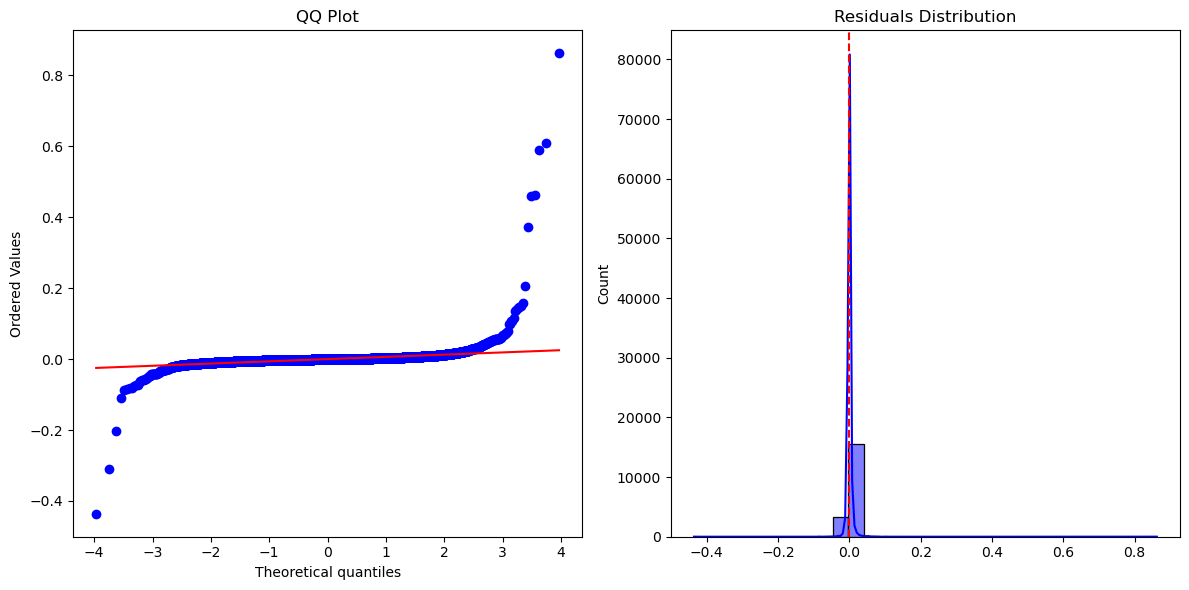

Shapiro-Wilk Test: ShapiroResult(statistic=0.2258111834526062, pvalue=0.0)


/Users/krys/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
import xgboost as xgb

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

mse_cv, mae_cv, rmse_cv, r2_cv, residuals_xgb = perform_cross_validation(X, y, xgboost_model, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

plot_residuals(residuals_xgb)

<h4>Random Forest</h4>

Average MSE: 0.00015887670398587092
Average MAE: 0.003338814625407941
Average RMSE: 0.011639657054381929
Average R²: 0.5442543241559806


/Users/krys/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


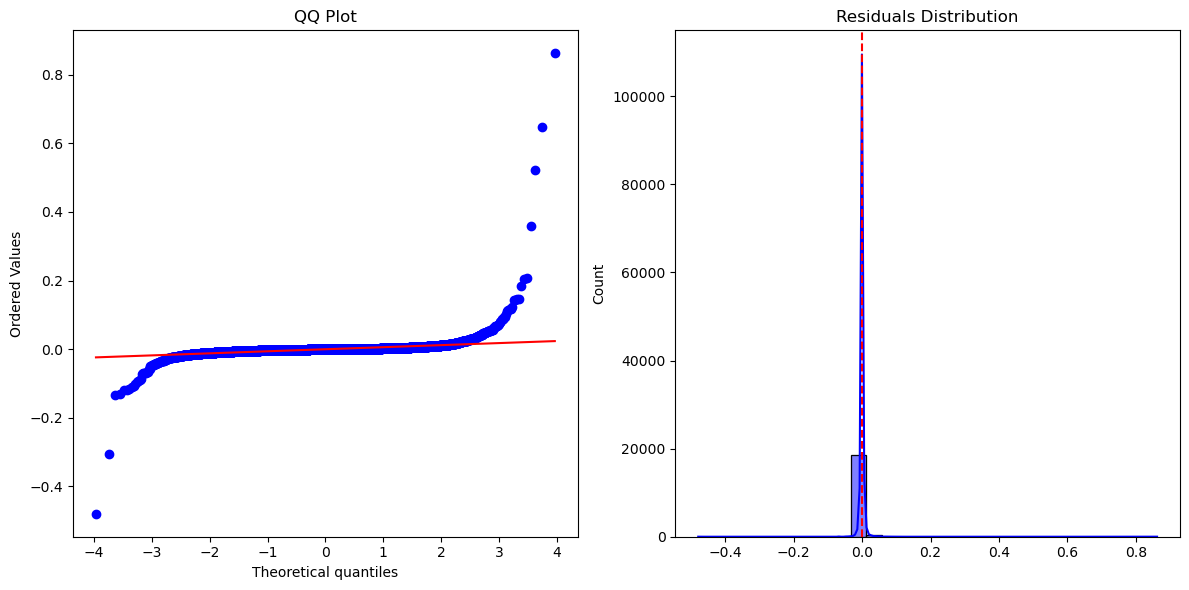

Shapiro-Wilk Test: ShapiroResult(statistic=0.2264094352722168, pvalue=0.0)


/Users/krys/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(random_state=42)

mse_cv, mae_cv, rmse_cv, r2_cv, residuals_rf = perform_cross_validation(X, y, random_forest, kf)
print("Average MSE:", mse_cv)
print("Average MAE:", mae_cv)
print("Average RMSE:", rmse_cv)
print("Average R²:", r2_cv)

plot_residuals(residuals_rf)

Wilcoxon Signed Rank Sum Test between XGBoost and Random Forest

In [10]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(residuals_xgb, residuals_rf)

print(f'Wilcoxon statistic: {stat}')
print(f'p-value: {p_value}')

significance = 0.05
if p_value < significance:
    print("Reject null hypothesis: There is a significant difference between the two models' residuals.")
else:
    print("Cannot reject null hypothesis: There is no significant difference between the two models' residuals.")

Wilcoxon statistic: 82220337.0
p-value: 1.9616517018557887e-22
Reject null hypothesis: There is a significant difference between the two models' residuals.


<h3>Feature Importance Analysis</h3>


Random Forest

                      Feature  Importance
8                accommodates    0.187853
19  review_scores_cleanliness    0.141064
12             minimum_nights    0.069668
14          number_of_reviews    0.067776
25          reviews_per_month    0.051308
10                   bedrooms    0.050686
9                   bathrooms    0.035244
23        review_scores_value    0.033022
11                       beds    0.032304
6                    latitude    0.023047


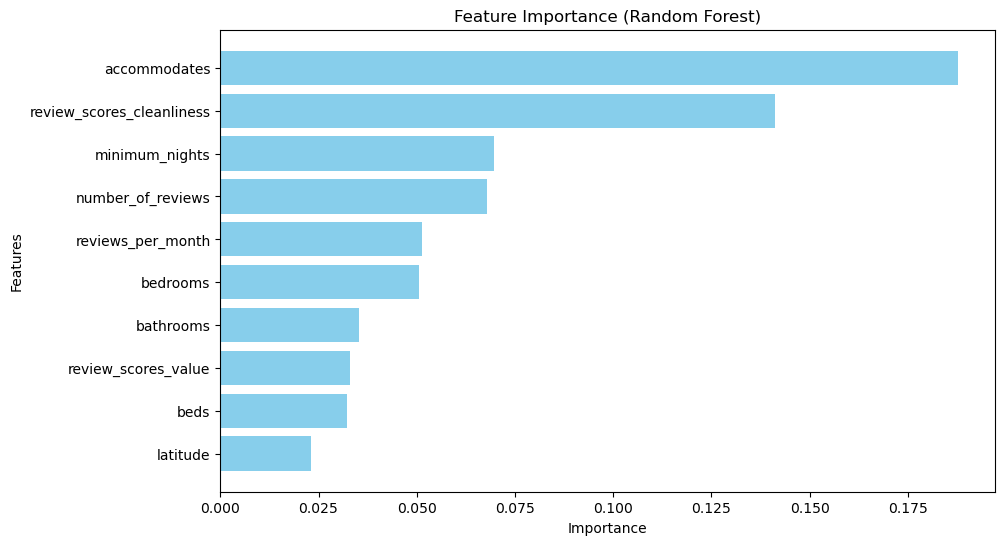

In [11]:
import matplotlib.pyplot as plt

feature_importances = random_forest.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_10_features = importance_df.head(10)
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

XGBoost

                      Feature  Importance
0                  host_since       276.0
12             minimum_nights       225.0
9                   bathrooms       188.0
8                accommodates       178.0
3   host_total_listings_count       158.0
11                       beds       148.0
6                    latitude       145.0
14          number_of_reviews       143.0
1          host_response_rate       139.0
19  review_scores_cleanliness       138.0


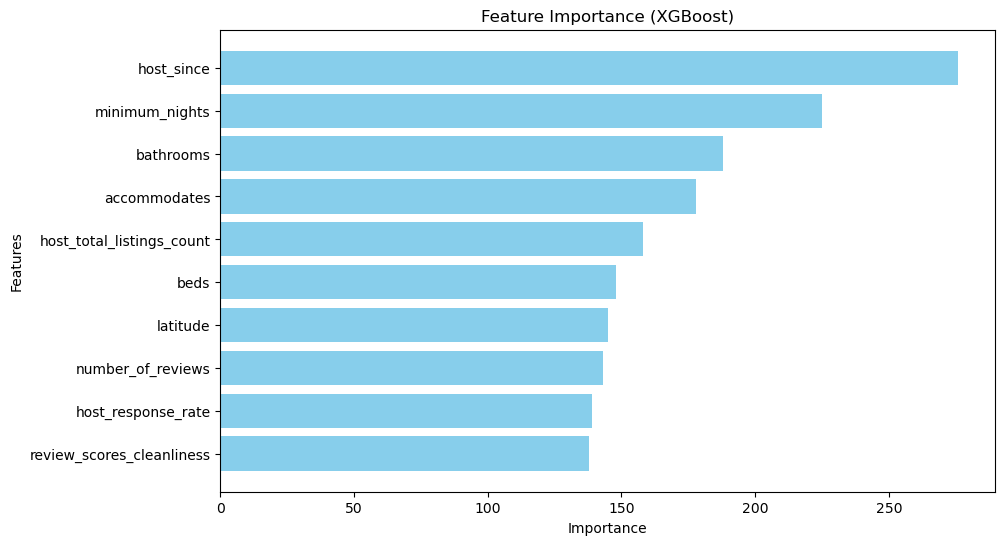

In [12]:
import matplotlib.pyplot as plt

importance_dict = xgboost_model.get_booster().get_score(importance_type='weight')

# Sort by importance
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.show()